In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import binary_dilation
from skimage.feature import structure_tensor, structure_tensor_eigenvalues


In [2]:
def extract_patches_from_edges(image_path, gt_path, r=3):
    """
    Original: Canny→patches + binary labels from dilated red mask.
    """
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image      = cv2.imread(image_path)
    gt_image   = cv2.imread(gt_path)

    # assume red mask on GT marks ridge
    red_mask = (gt_image[:,:,2] > 200) & (gt_image[:,:,1]<50) & (gt_image[:,:,0]<50)
    dilated_red_mask = binary_dilation(red_mask, np.ones((3,3)))

    edges = cv2.Canny(image_gray, 50, 200)

    h, w = image_gray.shape
    patches, labels = [], []
    for y in range(r, h-r):
        for x in range(r, w-r):
            if edges[y,x]==0: 
                continue
            lab = int(dilated_red_mask[y,x])
            p = image[y-r:y+r+1, x-r:x+r+1]
            if p.shape != (2*r+1,2*r+1,3): 
                continue
            patches.append(p)
            labels.append(lab)
    return np.array(patches), np.array(labels)

def load_full_dataset(image_dir, gt_dir):
    all_patches = []
    all_labels = []
    for i in tqdm(range(1, 81)):
        img_name = f"R_GImag{i:04d}.bmp"
        gt_name = f"GT_GoogleImage{i:03d}_Edge.bmp"
        image_path = os.path.join(image_dir, img_name)
        gt_path = os.path.join(gt_dir, gt_name)
        if os.path.exists(image_path) and os.path.exists(gt_path):
            patches, labels = extract_patches_from_edges(image_path, gt_path)
            all_patches.append(patches)
            all_labels.append(labels)

    all_patches = np.concatenate(all_patches, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Balance dataset
    pos_indices = np.where(all_labels == 1)[0]
    neg_indices = np.where(all_labels == 0)[0]
    n_samples = min(len(pos_indices), len(neg_indices))

    selected_pos = np.random.choice(pos_indices, n_samples, replace=False)
    selected_neg = np.random.choice(neg_indices, n_samples, replace=False)

    selected_indices = np.concatenate([selected_pos, selected_neg])
    np.random.shuffle(selected_indices)

    balanced_patches = all_patches[selected_indices]
    balanced_labels = all_labels[selected_indices]

    return balanced_patches, balanced_labels

def show_example_patches(patches, labels, label_filter=None, num=10):
    idxs = np.where(labels==label_filter)[0] if label_filter is not None else np.arange(len(patches))
    plt.figure(figsize=(10,2))
    for i,idx in enumerate(idxs[:num]):
        plt.subplot(1,num,i+1)
        plt.imshow(patches[idx])
        plt.title(labels[idx])
        plt.axis('off')
    plt.tight_layout(); plt.show()


In [3]:
# Cell 3 — Structure‑Tensor feature maps

def compute_structure_tensor_maps(gray, sigma=1.0):
    Jxx, Jxy, Jyy = structure_tensor(gray, sigma=sigma)
    ST = np.array([Jxx, Jxy, Jyy])
    λ1, λ2       = structure_tensor_eigenvalues(ST)
    strength    = np.sqrt(λ1)
    coherence   = (λ1 - λ2) / (λ1 + λ2 + 1e-12)
    orientation = 0.5 * np.arctan2(2*Jxy, Jxx - Jyy)
    return strength, coherence, orientation


In [4]:
def extract_patches_with_ST(image_path, gt_path, r=3, bucket=False, bins=None):
    """
    Returns:
      patches:   (N, (2r+1)^2*3 + (bucket? one-hot:3) ) float32
      labels:    (N,) {0,1}
    """
    image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)/255.0
    image      = cv2.imread(image_path)
    gt_image   = cv2.imread(gt_path)
    # same red mask logic
    red_mask = (gt_image[:,:,2]>200)&(gt_image[:,:,1]<50)&(gt_image[:,:,0]<50)
    red_mask = binary_dilation(red_mask, np.ones((3,3)))
    edges = cv2.Canny((image_gray*255).astype(np.uint8), 50,200)>0

    S, C, O = compute_structure_tensor_maps(image_gray)
    h,w = image_gray.shape

    feats, labs = [], []
    for y in range(r, h-r):
      for x in range(r, w-r):
        if not edges[y,x]: continue
        lab = int(red_mask[y,x])
        patch = image[y-r:y+r+1, x-r:x+r+1].astype(np.float32)/255.0
        flat  = patch.reshape(-1)  # ( (2r+1)^2 * 3, )
        s,c,o = S[y,x], C[y,x], O[y,x]
        if bucket:
          sb = np.digitize(s, bins['strength'])-1
          cb = np.digitize(c, bins['coherence'])-1
          ob = np.digitize(o, bins['orientation'])-1
          s_feat = np.eye(len(bins['strength'])-1)[sb]
          c_feat = np.eye(len(bins['coherence'])-1)[cb]
          o_feat = np.eye(len(bins['orientation'])-1)[ob]
          f = np.concatenate([flat, s_feat, c_feat, o_feat])
        else:
          f = np.concatenate([flat, [s,c,o]])
        feats.append(f); labs.append(lab)

    return np.stack(feats).astype(np.float32), np.array(labs).astype(np.float32)


In [5]:
def make_loader(X, y, bs=64):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y).unsqueeze(1))
    n = len(ds); t = int(0.8*n)
    tr, te = random_split(ds, [t, n-t])
    return DataLoader(tr, batch_size=bs, shuffle=True), DataLoader(te, batch_size=bs, shuffle=False)


In [6]:
class RidgeClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc3(x))

In [ ]:
image_dir = "web_dataset/images"
gt_dir    = "web_dataset/ground_truth"
patch_size=7  # 2*r+1
r = patch_size//2

# 1) ORIGINAL
orig_patches_list, orig_labels_list = [], []
for i in range(1, 81):
    img_name = f"R_GImag{i:04d}.bmp"
    gt_name  = f"GT_GoogleImage{i:03d}_Edge.bmp"
    ip = os.path.join(image_dir, img_name)
    gp = os.path.join(gt_dir,   gt_name)
    if os.path.exists(ip) and os.path.exists(gp):
        p, l = extract_patches_from_edges(ip, gp, r=r)
        orig_patches_list.append(p)
        orig_labels_list.append(l)

orig_patches = np.concatenate(orig_patches_list, axis=0)
orig_labels  = np.concatenate(orig_labels_list,  axis=0)
X_orig = orig_patches.reshape(len(orig_patches), -1).astype(np.float32)/255.0
y_orig = orig_labels.astype(np.float32)

# 2) ST-CONTINUOUS
st_feats_list, st_labels_list = [], []
for i in range(1, 81):
    img_name = f"R_GImag{i:04d}.bmp"
    gt_name  = f"GT_GoogleImage{i:03d}_Edge.bmp"
    ip = os.path.join(image_dir, img_name)
    gp = os.path.join(gt_dir,   gt_name)
    if os.path.exists(ip) and os.path.exists(gp):
        f, l = extract_patches_with_ST(ip, gp, r=r, bucket=False)
        st_feats_list.append(f)
        st_labels_list.append(l)

X_st = np.concatenate(st_feats_list, axis=0)
y_st = np.concatenate(st_labels_list, axis=0)

# Define bins based on ST continuous features
bins = {
  'strength': np.linspace(0, np.max(X_st[:,-3]), 6+1),
  'coherence': np.linspace(0, 1.0, 3+1),
  'orientation': np.linspace(-np.pi/2, np.pi/2, 16+1),
}

# 3) ST-BUCKETED
bkt_feats_list, bkt_labels_list = [], []
for i in range(1, 81):
    img_name = f"R_GImag{i:04d}.bmp"
    gt_name  = f"GT_GoogleImage{i:03d}_Edge.bmp"
    ip = os.path.join(image_dir, img_name)
    gp = os.path.join(gt_dir, gt_name)
    if os.path.exists(ip) and os.path.exists(gp):
        f, l = extract_patches_with_ST(ip, gp, r=r, bucket=True, bins=bins)
        bkt_feats_list.append(f)
        bkt_labels_list.append(l)

X_bkt = np.concatenate(bkt_feats_list, axis=0)
y_bkt = np.concatenate(bkt_labels_list, axis=0)

# Create DataLoaders
loader_orig = make_loader(X_orig, y_orig)
loader_st   = make_loader(X_st,   y_st)
loader_bkt  = make_loader(X_bkt,  y_bkt)

print("Original:", X_orig.shape, y_orig.shape)
print("ST-Continuous:", X_st.shape, y_st.shape)
print("ST-Bucketed:", X_bkt.shape, y_bkt.shape)

Original: (7138070, 147) (7138070,)
ST-Continuous: (7138070, 150) (7138070,)
ST-Bucketed: (7138070, 172) (7138070,)


In [8]:
print(torch.version.cuda, torch.cuda.is_available())

12.6 True


In [13]:
def train_eval(loader, in_dim, lr=3e-3, epochs=2):
    train_loader, test_loader = loader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # change to "mps" on mac
    print(f"Training on {device}.\n")

    model = RidgeClassifier(in_dim).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCELoss()

    for ep in range(epochs):
        model.train()
        for xb,yb in tqdm(train_loader, desc=f"Epoch {ep+1}"):
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            opt.step()
        # eval
        model.eval()
        tot, cnt, acc = 0.,0,0
        with torch.no_grad():
            for xb,yb in test_loader:
                xb,yb = xb.to(device), yb.to(device)
                out = model(xb)
                tot += loss_fn(out,yb).item()*len(xb)
                cnt += len(xb)
                pred = (out>0.5).float()
                acc += (pred==yb).sum().item()
        print(f"  Val Loss: {tot/cnt:.4f}, Acc: {acc/cnt:.3f}")
    return model

# run all three
print(">>> ORIGINAL")
m0 = train_eval(loader_orig, X_orig.shape[1])

print(">>> ST CONTINUOUS")
m1 = train_eval(loader_st, X_st.shape[1])

print(">>> ST BUCKETED")
m2 = train_eval(loader_bkt, X_bkt.shape[1])


>>> ORIGINAL
Training on cuda.



Ep0: 100%|██████████| 89226/89226 [03:26<00:00, 431.18it/s]


  Val Loss: 0.0137, Acc: 0.995


Ep1: 100%|██████████| 89226/89226 [03:24<00:00, 436.64it/s]


  Val Loss: 0.0136, Acc: 0.995
>>> ST CONTINUOUS
Training on cuda.



Ep0: 100%|██████████| 89226/89226 [03:30<00:00, 424.16it/s]


  Val Loss: 0.0139, Acc: 0.995


Ep1: 100%|██████████| 89226/89226 [03:36<00:00, 412.61it/s]


  Val Loss: 0.0119, Acc: 0.996
>>> ST BUCKETED
Training on cuda.



Ep0: 100%|██████████| 89226/89226 [03:39<00:00, 406.81it/s]


  Val Loss: 0.0137, Acc: 0.995


Ep1: 100%|██████████| 89226/89226 [03:28<00:00, 427.27it/s]


  Val Loss: 0.0152, Acc: 0.995


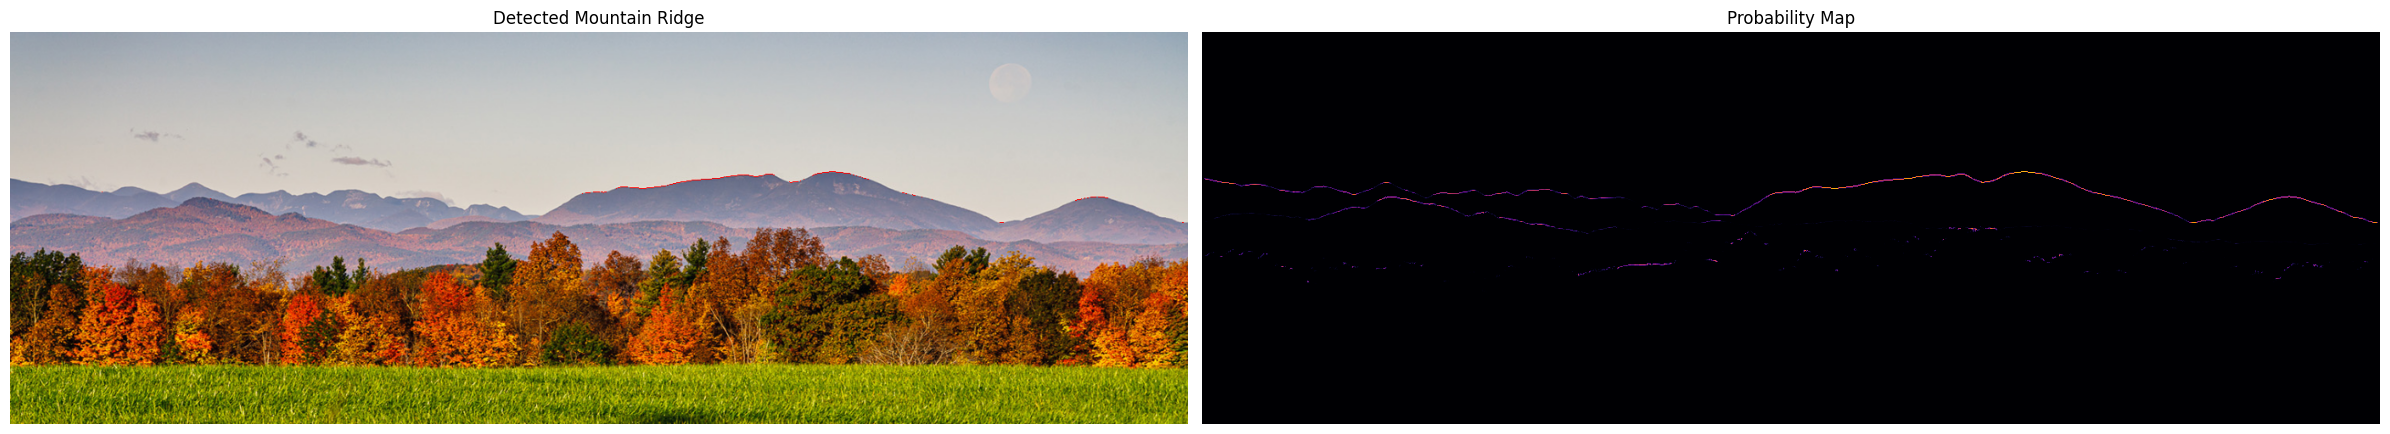

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load & resize
test_path = "test_images/middlebury.jpg"
img0 = cv2.imread(test_path)
h0, w0 = img0.shape[:2]
new_w = 1388
new_h = int(new_w * h0 / w0)
img = cv2.resize(img0, (new_w, new_h))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0

# edge map
edges = cv2.Canny((gray * 255).astype(np.uint8), 50, 200) > 0

# prepare output
h, w = gray.shape
output_img = img.copy()
prob_map = np.zeros((h, w), dtype=np.float32)

# precompute ST maps
S, C, O = compute_structure_tensor_maps(gray)

# slide window
for y in range(r, h - r):
    for x in range(r, w - r):
        if not edges[y, x]:
            continue
        patch = img[y-r:y+r+1, x-r:x+r+1].astype(np.float32) / 255.0
        flat = patch.reshape(-1)
        # bucket ST features
        sb = np.digitize(S[y, x], bins['strength']) - 1
        cb = np.digitize(C[y, x], bins['coherence']) - 1
        ob = np.digitize(O[y, x], bins['orientation']) - 1
        s_feat = np.eye(len(bins['strength'])-1)[sb]
        c_feat = np.eye(len(bins['coherence'])-1)[cb]
        o_feat = np.eye(len(bins['orientation'])-1)[ob]
        feat = np.concatenate([flat, s_feat, c_feat, o_feat]).astype(np.float32)
        inp = torch.from_numpy(feat).unsqueeze(0).to(device)
        with torch.no_grad():
            p = m2(inp).item() # model 2 (ST-Bucketed)
        prob_map[y, x] = p
        if p > 0.8:
            output_img[y, x] = [0, 0, 255]  # mark ridge in red (BGR)

# visualize
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Detected Mountain Ridge")
plt.imshow(gray)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Probability Map")
plt.imshow(prob_map, cmap='inferno', vmin=0, vmax=1)
plt.axis("off")
plt.tight_layout()
plt.show()

WHat needs to change: Right now we are building the prob map before hand... we should be building it only for the following window. Same goes for the structure tensors. Should build them for each pixel during construction.

In [ ]:
def find_ridge(prob_map, delta=1, epsilon=1e-6):
    H, W = prob_map.shape
    cost = np.full((H, W), np.inf)
    backtrack = np.full((H, W), -1, dtype=int)

    # Convert prob_map to cost map using negative log
    log_cost = -np.log(prob_map + epsilon)

    # Initialize first column
    cost[:, 0] = log_cost[:, 0]

    for x in range(1, W):
        for y in range(H):
            y_min = max(y - delta, 0)
            y_max = min(y + delta + 1, H)
            for yy in range(y_min, y_max):
                transition_cost = abs(y - yy)
                total_cost = cost[yy, x-1] + transition_cost + log_cost[y, x]
                if total_cost < cost[y, x]:
                    cost[y, x] = total_cost
                    backtrack[y, x] = yy

    # Backtrace the path
    ridge = np.zeros(W, dtype=int)
    ridge[-1] = np.argmin(cost[:, -1])
    for x in range(W - 2, -1, -1):
        ridge[x] = backtrack[ridge[x + 1], x + 1]

    return ridge

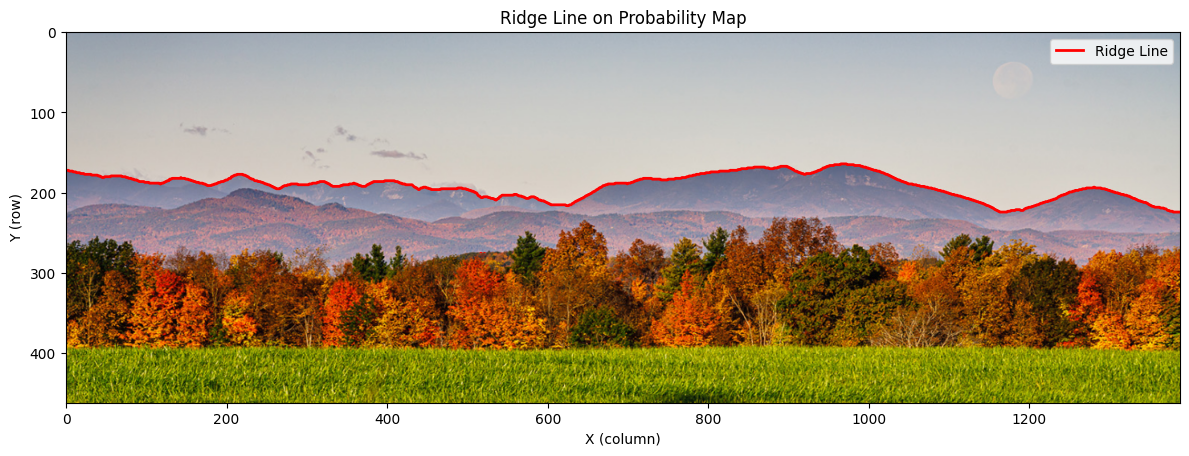

In [32]:
ridge = find_ridge(prob_map, delta=2, epsilon=1e-6)

def plot_ridge(ridge):
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.plot(range(len(ridge)), ridge, color='red', linewidth=2, label='Ridge Line')
    plt.title('Ridge Line on Probability Map')
    plt.xlabel('X (column)')
    plt.ylabel('Y (row)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ridge(ridge)